In [51]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data
import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression
import utils

to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

In [2]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")

In [3]:
msci_world = get_data(ticker="^990100-USD-STRD", start_date="2008-01-01", end_date="2016-01-01")

In [4]:
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())

In [5]:
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})

In [6]:
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))

In [7]:
sentences

date,label,sentence,embeddings
date,i64,str,list[f64]
2008-08-08,0,"""Arrested Bissa…","[-0.033539, 0.04306, … 0.019379]"
2008-08-11,1,"""New York Senat…","[-0.034912, 0.019608, … 0.00705]"
2008-08-12,0,"""Gold plunges t…","[-0.044525, 0.028824, … -0.011269]"
2008-08-13,0,"""DreamWorks Ani…","[-0.032074, 0.025146, … 0.015137]"
2008-08-14,1,"""Temecula Valle…","[-0.043121, 0.02681, … 0.010452]"
…,…,…,…
2015-12-04,1,"""Sprott Focus T…","[-0.014244, 0.033936, … -0.007206]"
2015-12-07,0,"""Rentrak Announ…","[0.006672, 0.037231, … 0.026917]"
2015-12-08,0,"""ATWOOD OCEANIC…","[-0.003252, 0.035645, … 0.014435]"


In [39]:
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))

In [9]:
reducer = umap.UMAP()

In [10]:
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())

In [40]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))

C:\Users\faune\AppData\Local\Temp\ipykernel_40088\43547788.py:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))


<Axes: xlabel='x', ylabel='y'>

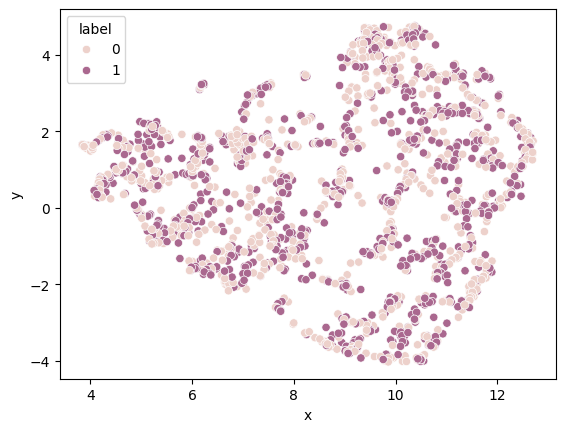

In [49]:
sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

In [29]:
# frame.drop_nulls().with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'year').select(pl.col('year').unique()) #.to_pandas()